# Stock-Market-Index-Price-Prediction

### Final Project for Introduction to Deep Learning Course at University of South Florida
### Team Members: Jun Kim, Gerardo Wibmer Gonzalez, Paul-Ann Francis, Tahsun Rahman Khan

## Overview
This project aims to predict the closing prices of stock market indices using deep learning models built with Python and TensorFlow. We have developed a two-model approach to achieve this goal. The first model (Model 1) predicts the closing price using four input features (Open, High, Low, and Volume) for a specific date. The second model (Model 2) predicts the future values of each feature based on their respective historical data. By combining the predictions from these two models, we can estimate the closing price for any given day.

Although our project focuses on predicting the S&P 500 index prices, the code can be easily modified to predict the prices of any stock.

## Data
The data used in this project consists of daily stock market index prices, including Open, High, Low, Close, and Volume. We have used the historical price data of the S&P 500 index, obtained from Yahoo Finance, to train, validate, and test our models.

## Approach
1. Preprocessing: The raw data is preprocessed to create a windowed dataset, which includes the necessary features and target variables.
2. Model Training: We train separate instances of Model 2 for each feature (Open, High, Low, and Volume) using their historical data. This results in four different models that predict future values for each feature. Then, we train Model 1 using the combined features from Model 2's predictions.
3. Hyperparameter Tuning: We used grid search to find the best hyperparameters for our models. The optimal hyperparameters and their corresponding performance metrics are stored in CSV files under the hyperparameters/ directory.
4. Prediction: We input the predicted values of Open, High, Low, and Volume from Model 2 into Model 1 to predict the closing price for any given day.

## Repository Structure
- models/: Contains the saved deep learning models (Model 1 and Model 2 instances) for each feature.
- hyperparameters/: Contains CSV files with the optimal hyperparameters and their corresponding performance metrics, obtained through grid search.
- notebooks/: Contains Jupyter notebooks for data preprocessing, model training, and evaluation.
- README.md: Provides an overview of the project, including the approach, data, and repository structure.

## Dependencies
- Python 3.8 or higher
- datetime
- matplotlib
- NumPy
- pandas
- scikit-learn
- TensorFlow
- Keras
- yfinance

## License
This project is licensed under the Apache License 2.0. See LICENSE file for details.

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LeakyReLU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras.regularizers as regularizers
import yfinance as yf

# Preprocessing

In [2]:
TRAIN_START_DATE = '1960-01-01'
TRAIN_END_DATE = '2015-12-31'
PREDICT_START_DATE = '2016-01-01'
PREDICT_END_DATE = '2019-12-31'
WINDOW_SIZE = 7

In [3]:
# Download S&P 500 data from Yahoo Finance
df = yf.download('^GSPC', start=TRAIN_START_DATE, end=PREDICT_END_DATE)

df = df.reset_index()

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

# Drop columns that are not needed
df = df.drop(columns=['Adj Close'])

# Create actual close df for plotting
actual_close_df = df['Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Split data into train and test sets
X_train = df[:PREDICT_START_DATE]
X_test = df[PREDICT_START_DATE:PREDICT_END_DATE]
y_train = X_train.pop('Close')
y_test = X_test.pop('Close')

In [5]:
date_df_all = df.index
date_df_train = y_train.index
date_df_test = y_test.index

In [36]:
X_train.shape, X_test.shape

((14096, 4), (1005, 4))

In [37]:
y_train.shape, y_test.shape

((14096,), (1005,))

In [6]:
# Functions to create windowed dataset
def df_to_windowed_df(feature, df, window_size, start_date, end_date):
    """Converts a dataframe into a windowed dataframe and date list"""
    df = df[start_date:end_date]
    date_list = df.index.to_list()
    feature_values = df[feature].to_numpy()
    windowed_df = []
    for i in range(len(feature_values) - window_size):
        windowed_df.append(feature_values[i:i+window_size])
    return np.array(windowed_df), date_list[window_size:]

def windowed_df_to_date_X_y(windowed_df, date_list):
    """Converts a windowed dataframe and date list into a date, X, and y dataframe"""
    date_df = []
    X_df = []
    y_df = []
    for i in range(len(windowed_df) - 1):  # Modify the range to exclude the last window
        date_df.append(date_list[i + 1])   # Shift date by 1
        X_df.append(windowed_df[i])
        if windowed_df.ndim == 3:
            y_df.append(windowed_df[i + 1][-1][-1])  # Shift the target y value by 1 (for 3D input)
        else:
            y_df.append(windowed_df[i + 1][-1])  # Shift the target y value by 1 (for 2D input)
    return np.array(date_df), np.array(X_df), np.array(y_df)

### Create Train Data

In [7]:
# Create windowed dataframes and date_list
open_windowed_df_train, date_list_train = df_to_windowed_df('Open', df, window_size=WINDOW_SIZE, start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
high_windowed_df_train, _ = df_to_windowed_df('High', df, window_size=WINDOW_SIZE, start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
low_windowed_df_train, _ = df_to_windowed_df('Low', df, window_size=WINDOW_SIZE, start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
volume_windowed_df_train, _ = df_to_windowed_df('Volume', df, window_size=WINDOW_SIZE, start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)

In [8]:
# Create test dataframes for each feature
_, X_open_train, y_open_train = windowed_df_to_date_X_y(open_windowed_df_train, date_list_train)
_, X_high_train, y_high_train = windowed_df_to_date_X_y(high_windowed_df_train, date_list_train)
_, X_low_train, y_low_train = windowed_df_to_date_X_y(low_windowed_df_train, date_list_train)
_, X_volume_train, y_volume_train = windowed_df_to_date_X_y(volume_windowed_df_train, date_list_train)

In [32]:
X_open_train.shape, X_high_train.shape, X_low_train.shape, X_volume_train.shape

((14088, 7), (14088, 7), (14088, 7), (14088, 7))

In [33]:
y_open_train.shape, y_high_train.shape, y_low_train.shape, y_volume_train.shape

((14088,), (14088,), (14088,), (14088,))

### Create Test Data

In [9]:
# Create windowed dataframes and date_list
open_windowed_df_test, date_list_test = df_to_windowed_df('Open', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
high_windowed_df_test, _ = df_to_windowed_df('High', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
low_windowed_df_test, _ = df_to_windowed_df('Low', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
volume_windowed_df_test, _ = df_to_windowed_df('Volume', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)

In [10]:
# Create test dataframes for each feature
date_df_test, X_open_test, y_open_test = windowed_df_to_date_X_y(open_windowed_df_test, date_list_test)
_, X_high_test, y_high_test = windowed_df_to_date_X_y(high_windowed_df_test, date_list_test)
_, X_low_test, y_low_test = windowed_df_to_date_X_y(low_windowed_df_test, date_list_test)
_, X_volume_test, y_volume_test = windowed_df_to_date_X_y(volume_windowed_df_test, date_list_test)

In [34]:
X_open_test.shape, X_high_test.shape, X_low_test.shape, X_volume_test.shape

((997, 7), (997, 7), (997, 7), (997, 7))

In [35]:
y_open_test.shape, y_high_test.shape, y_low_test.shape, y_volume_test.shape

((997,), (997,), (997,), (997,))

# Model 2

In [11]:
class CreateModel:
    def __init__(self, feature, dates, X_train, y_train, window_size, params=None):
        self.feature = feature
        self.dates = dates
        self.X = X_train
        self.y = y_train
        self.window_size = window_size
        self.params = params

        if self.params is None:
            self.best_model = self.train_model(True)
        else:
            self.best_model = self.train_model(False)

    def create_model(
        self,
        lstm_units=64,
        dense_units=32,
        learning_rate=0.001,
        lstm_activation="tanh",
        dense_activation="relu",
        lstm_regularizer=None,
        dense_regularizer=None,
    ):
        model = Sequential(
            [
                Input((self.window_size, 1)),
                LSTM(
                    lstm_units,
                    activation=lstm_activation,
                    kernel_regularizer=lstm_regularizer,
                ),
            ]
        )

        if dense_activation == "leaky_relu":
            model.add(Dense(dense_units, kernel_regularizer=dense_regularizer))
            model.add(LeakyReLU(alpha=0.3))
            model.add(Dense(dense_units, kernel_regularizer=dense_regularizer))
            model.add(LeakyReLU(alpha=0.3))
        else:
            model.add(
                Dense(
                    dense_units,
                    activation=dense_activation,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(
                Dense(
                    dense_units,
                    activation=dense_activation,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(Dense(1))

        model.compile(
            loss="mse",
            optimizer=Adam(learning_rate=learning_rate),
            metrics=["mean_absolute_error"],
        )

        return model

    def train_model(self, grid_search):
        # Check if GPU is available
        if tf.config.list_physical_devices("GPU"):
            print("Using GPU")
            # Set the device to GPU:0
            with tf.device("/GPU:0"):
                best_model = self.train_model_helper(grid_search)
        else:
            print("Using CPU")
            # If GPU is not available, perform grid search on CPU
            best_model = self.train_model_helper(grid_search)

        return best_model

    def train_model_helper(self, grid_search):
        # Wrap the create_model function with KerasRegressor
        model = KerasRegressor(build_fn=self.create_model, verbose=1)

        # Define the grid search parameters
        param_grid = {
            "lstm_units": [8, 16, 32],
            "dense_units": [4, 8, 16],
            "learning_rate": [0.0001, 0.001],
            "epochs": [10, 30],
            "batch_size": [8, 16],
            "lstm_activation": ["tanh", "relu", "leaky_relu"],
            "dense_activation": ["relu", "elu"],
            "lstm_regularizer": [
                tf.keras.regularizers.l1(0.01),
                tf.keras.regularizers.l2(0.01),
                tf.keras.regularizers.l1_l2(0.01),
            ],
            "dense_regularizer": [
                tf.keras.regularizers.l1(0.01),
                tf.keras.regularizers.l2(0.01),
                tf.keras.regularizers.l1_l2(0.01),
            ],
        }

        # Create the GridSearchCV object
        grid = GridSearchCV(
            estimator=model, param_grid=param_grid, n_jobs=-30, cv=2, verbose=1
        )

        # Split the data into training and validation
        q_80 = int(len(self.dates) * 0.8)

        self.dates_train, X_train, y_train = (
            self.dates[:q_80],
            self.X[:q_80],
            self.y[:q_80],
        )
        self.dates_val, X_val, y_val = self.dates[q_80:], self.X[q_80:], self.y[q_80:]

        # Flatten the training data for GridSearchCV
        X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))
        y_train_flat = y_train.flatten()

        if grid_search:
            # Perform grid search
            grid_result = grid.fit(X_train_flat, y_train_flat)

            # Print the best hyperparameters
            print(
                "Best score: %f using %s"
                % (grid_result.best_score_, grid_result.best_params_)
            )

            # Create a model with the best hyperparameters
            best_params = grid_result.best_params_

            # Save the best hyperparameters
            best_params_df = pd.DataFrame(best_params, index=[0])
            best_params_df.to_csv(f"{self.feature}_best_params.csv", index=False)

            best_epochs = best_params.pop("epochs")
            best_batch_size = best_params.pop("batch_size")
            best_model = self.create_model(**best_params)
        else:
            print("Using best hyperparameters from previous run")
            best_epochs = self.params.pop("epochs")
            best_batch_size = self.params.pop("batch_size")
            best_model = self.create_model(**self.params)

        # Train the best model with the training data using default batch_size and epochs
        history = best_model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=best_epochs,
            batch_size=best_batch_size,
        )
        self.print_metrics(history)
        self.plot_learning_curves(history)

        return best_model

    def print_metrics(self, history):
        # Get the training and validation loss and mean absolute error (MAE) from history
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        train_mae = history.history["mean_absolute_error"]
        val_mae = history.history["val_mean_absolute_error"]

        # Calculate the final MSE and MAE for training and validation
        final_train_mse = train_loss[-1]
        final_val_mse = val_loss[-1]
        final_train_mae = train_mae[-1]
        final_val_mae = val_mae[-1]

        # Print the results
        print("Training metrics:")
        print(f"MSE: {final_train_mse}, MAE: {final_train_mae}")
        print("Validation metrics:")
        print(f"MSE: {final_val_mse}, MAE: {final_val_mae}")

    def plot_learning_curves(self, history):
        # Get the training and validation loss and mean absolute error (MAE) from history
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        train_mae = history.history["mean_absolute_error"]
        val_mae = history.history["val_mean_absolute_error"]

        # Get the number of epochs
        epochs = range(1, len(train_loss) + 1)

        # Plot the training and validation loss
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_loss, "r", label="Training Loss")
        plt.plot(epochs, val_loss, "b", label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

        # Plot the training and validation MAE
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_mae, "r", label="Training MAE")
        plt.plot(epochs, val_mae, "b", label="Validation MAE")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.legend()
        plt.title("Training and Validation Mean Absolute Error")
        plt.show()

## Only run when you're want to grid search

In [12]:
# print("Creating Open Model")
# open_model = CreateModel('Open', date_df_train, X_open_train, y_open_train, WINDOW_SIZE)
# print("Creating High Model")
# high_model = CreateModel('High', date_df_train, X_high_train, y_high_train, WINDOW_SIZE)
# print("Creating Low Model")
# low_model = CreateModel('Low', date_df_train, X_low_train, y_low_train, WINDOW_SIZE)
# print("Creating Volume Model")
# volume_model = CreateModel('Volume', date_df_train, X_volume_train, y_volume_train, WINDOW_SIZE)
# print("Done")

## Only Run if you want to train and save the models

In [13]:
def parse_regularizer(reg_str):
    # A regex pattern to match the regularizer type and value from the string.
    pattern = r"tf.keras.regularizers.(\w+)\(([\d\.]+)\)"
    match = re.match(pattern, reg_str)
    if match:
        # The type of the regularizer is the first group in the match.
        reg_type = match.group(1)
        # The value of the regularizer is the second group in the match.
        reg_value = float(match.group(2))
        if reg_type == "l1":
            return regularizers.l1(reg_value)
        elif reg_type == "l2":
            return regularizers.l2(reg_value)
        elif reg_type == "l1_l2":
            return regularizers.l1_l2(l1=reg_value, l2=reg_value)
    else:
        raise ValueError(f"Unknown regularizer: {reg_str}")

### Open

Using GPU
Using best hyperparameters from previous run
Epoch 1/10


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_151/2792147926.py:82: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-30 16:22:46.262419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - ETA: 0s - loss: 17168.2480 - mean_absolute_error: 25.2319

2023-04-30 16:24:54.345182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - 137s 97ms/step - loss: 17168.2480 - mean_absolute_error: 25.2319 - val_loss: 676.7191 - val_mean_absolute_error: 20.9671
Epoch 2/10
1410/1410 [==============================] - 136s 96ms/step - loss: 151.6042 - mean_absolute_error: 5.4925 - val_loss: 2275.1965 - val_mean_absolute_error: 41.4063
Epoch 3/10
1410/1410 [==============================] - 131s 93ms/step - loss: 161.6114 - mean_absolute_error: 5.6928 - val_loss: 827.8750 - val_mean_absolute_error: 23.8400
Epoch 4/10
1410/1410 [==============================] - 132s 93ms/step - loss: 139.5970 - mean_absolute_error: 5.2346 - val_loss: 995.6036 - val_mean_absolute_error: 26.7100
Epoch 5/10
1410/1410 [==============================] - 129s 92ms/step - loss: 147.2817 - mean_absolute_error: 5.3960 - val_loss: 510.4943 - val_mean_absolute_error: 16.3668
Epoch 6/10
1410/1410 [==============================] - 131s 93ms/step - loss: 137.7468 - mean_absolute_error: 5.2795 - val_loss: 1926.49

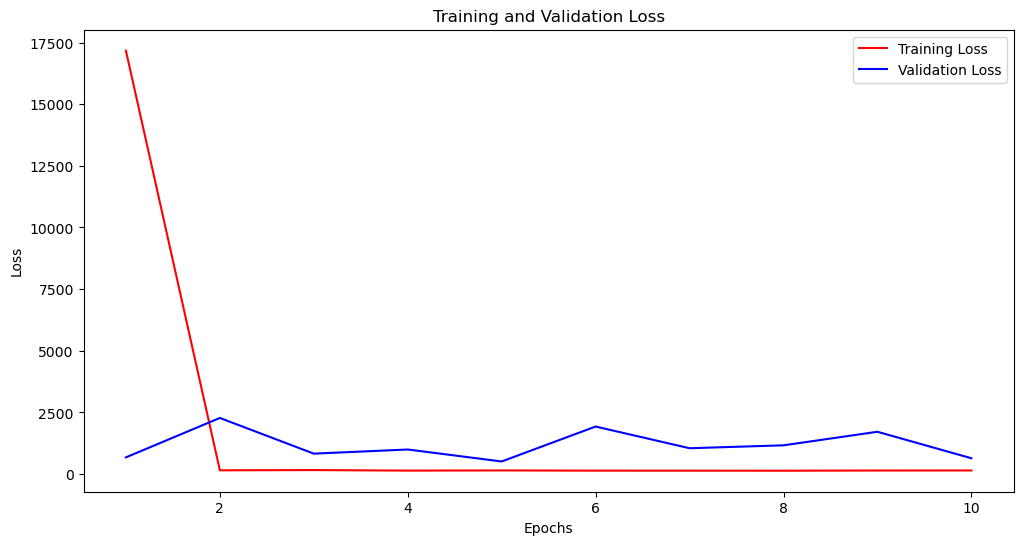

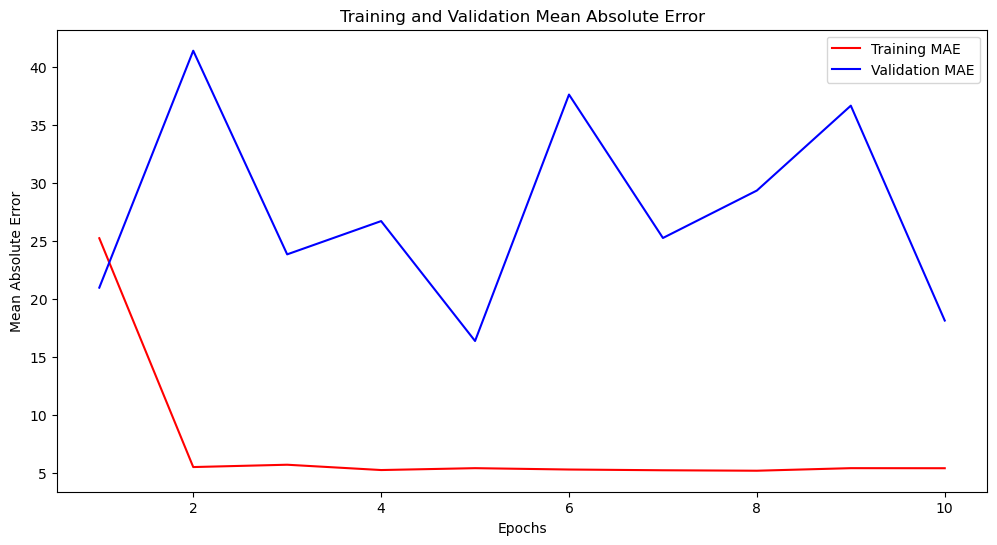

In [51]:
open_params = pd.read_csv('../hyperparameters/Open_best_params.csv').to_dict(orient='records')[0]

# Convert regularizer strings to actual regularizer instances.
open_params['dense_regularizer'] = parse_regularizer(open_params['dense_regularizer'])
open_params['lstm_regularizer'] = parse_regularizer(open_params['lstm_regularizer'])

open_model = CreateModel('Open', date_df_train, X_open_train, y_open_train, WINDOW_SIZE, params=open_params)

 5/32 [===>..........................] - ETA: 0s

2023-04-30 16:44:33.668195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


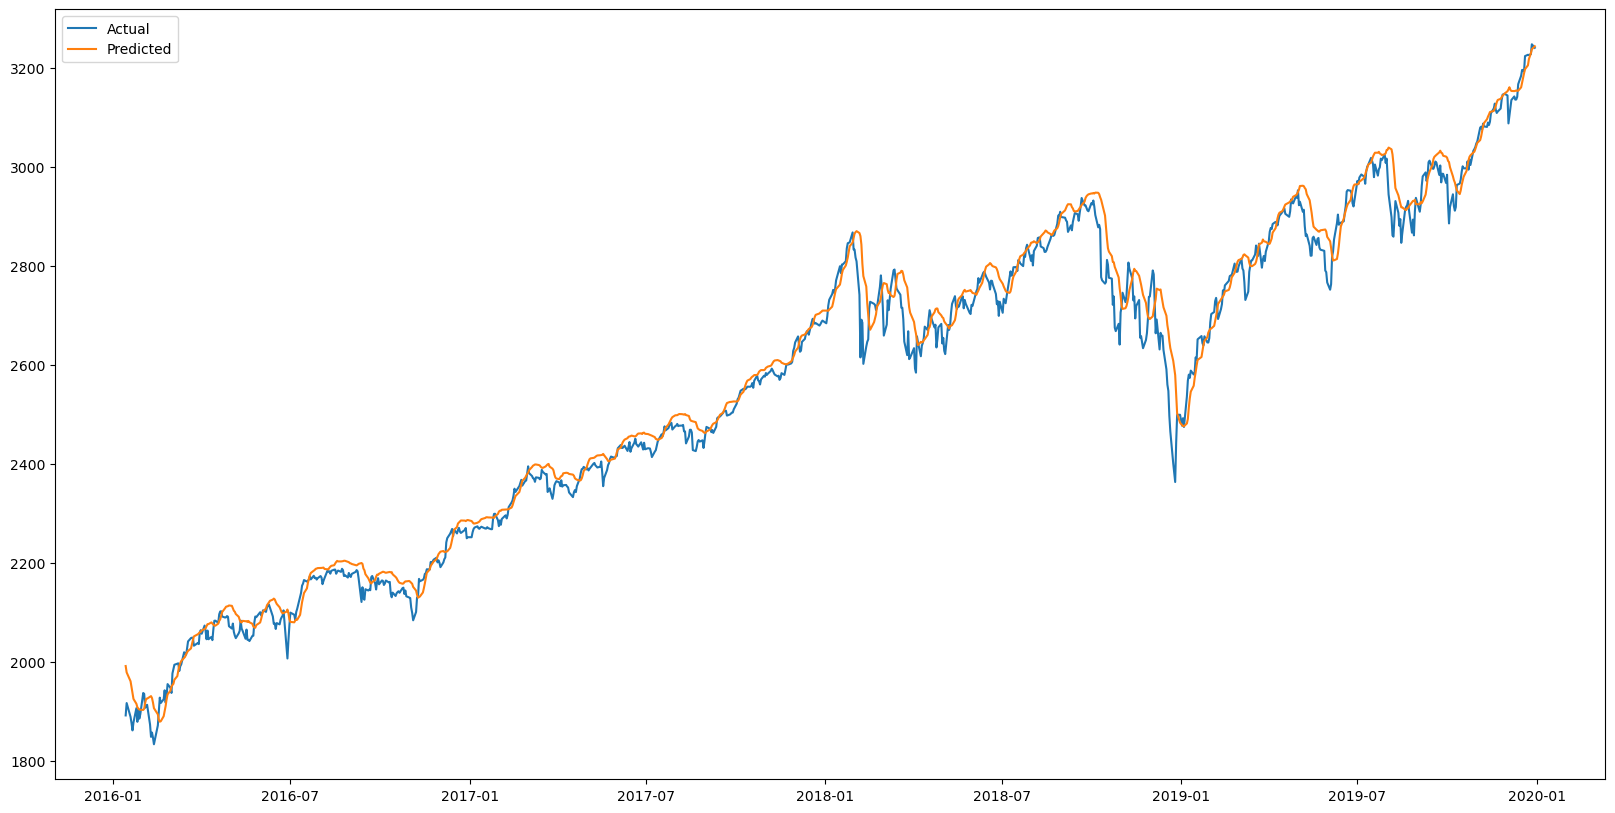

In [52]:
open_predictions = open_model.best_model.predict(X_open_test).flatten()

plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Open'][date_df_all.size-date_df_test.size:], label='Actual')
plt.plot(date_df_test, open_predictions, label='Predicted')
plt.legend()

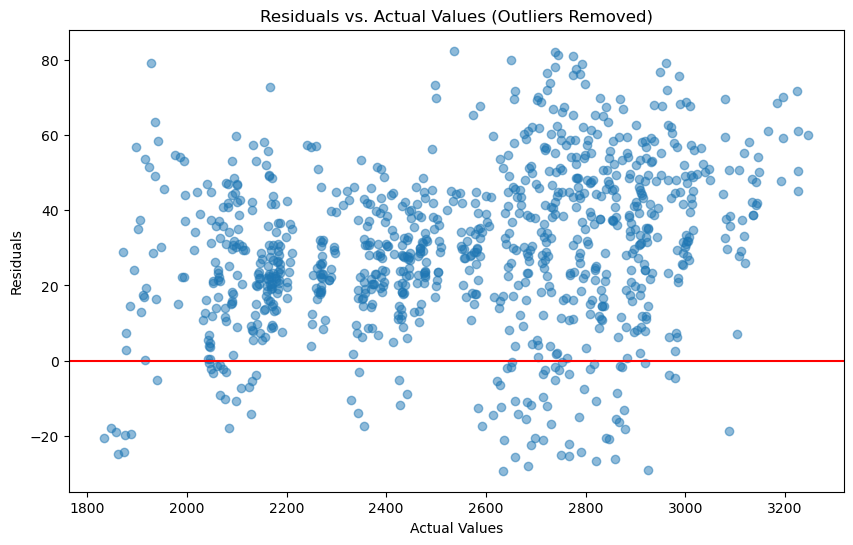

In [17]:
# Plot residuals
residuals = y_open_test - open_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_open_test[np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()

In [38]:
open_model.best_model.save('../models/open_model.h5')

### High

Using GPU
Using best hyperparameters from previous run
Epoch 1/30


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_151/2792147926.py:82: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-30 17:01:52.967709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - ETA: 0s - loss: 6218.6904 - mean_absolute_error: 15.4861

2023-04-30 17:03:56.845099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - 132s 93ms/step - loss: 6218.6904 - mean_absolute_error: 15.4861 - val_loss: 1088.1515 - val_mean_absolute_error: 28.1106
Epoch 2/30
1410/1410 [==============================] - 129s 91ms/step - loss: 133.7372 - mean_absolute_error: 5.8059 - val_loss: 658.4181 - val_mean_absolute_error: 20.5655
Epoch 3/30
1410/1410 [==============================] - 128s 90ms/step - loss: 149.9059 - mean_absolute_error: 6.1391 - val_loss: 596.8451 - val_mean_absolute_error: 19.1552
Epoch 4/30
1410/1410 [==============================] - 126s 89ms/step - loss: 149.0370 - mean_absolute_error: 6.2209 - val_loss: 599.5727 - val_mean_absolute_error: 17.4479
Epoch 5/30
1410/1410 [==============================] - 126s 90ms/step - loss: 149.8330 - mean_absolute_error: 6.2095 - val_loss: 580.0342 - val_mean_absolute_error: 17.1350
Epoch 6/30
1410/1410 [==============================] - 126s 90ms/step - loss: 146.2583 - mean_absolute_error: 6.1712 - val_loss: 541.8690

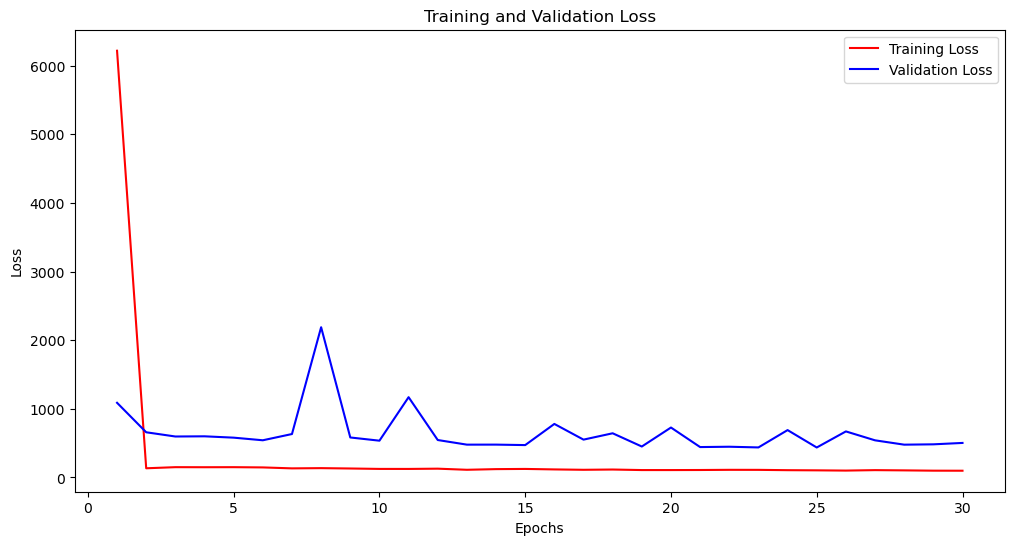

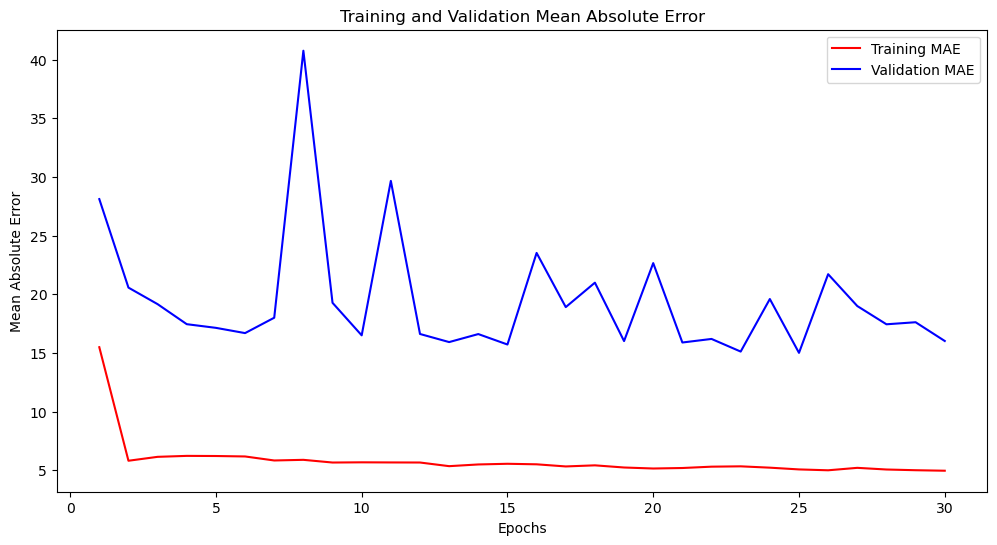

In [53]:
high_params = pd.read_csv('../hyperparameters/High_best_params.csv').to_dict(orient='records')[0]

# Convert regularizer strings to actual regularizer instances.
high_params['dense_regularizer'] = parse_regularizer(high_params['dense_regularizer'])
high_params['lstm_regularizer'] = parse_regularizer(high_params['lstm_regularizer'])

high_model = CreateModel('High', date_df_train, X_high_train, y_high_train, WINDOW_SIZE, params=high_params)

 4/32 [==>...........................] - ETA: 0s

2023-04-30 18:06:26.404083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


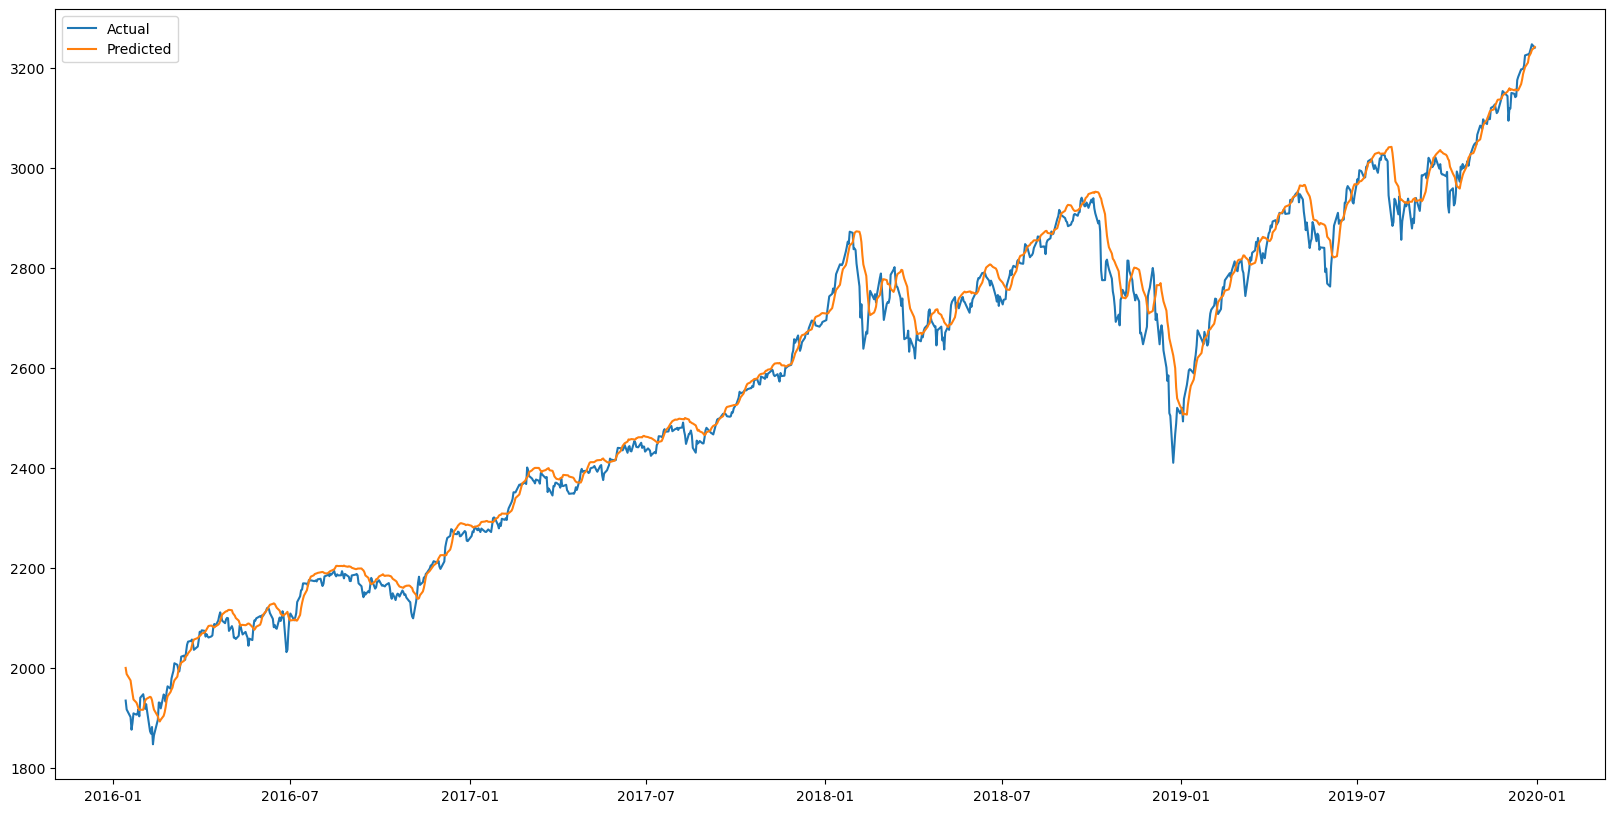

In [54]:
high_predictions = high_model.best_model.predict(X_high_test).flatten()

plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['High'][date_df_all.size-date_df_test.size:], label='Actual')
plt.plot(date_df_test, high_predictions, label='Predicted')
plt.legend()

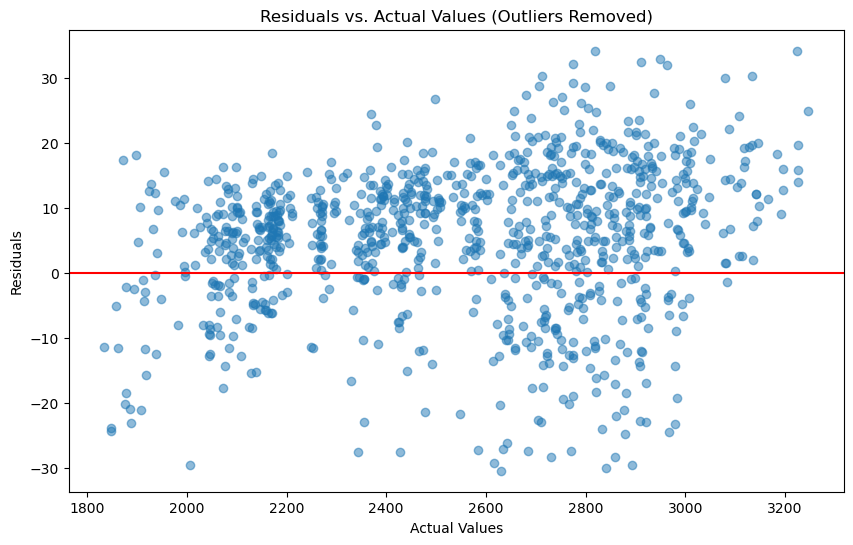

In [22]:
# Plot residuals
residuals = y_open_test - high_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_open_test[np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()

In [39]:
high_model.best_model.save('../models/high_model.h5')

### Low

Using GPU
Using best hyperparameters from previous run
Epoch 1/30


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_151/2792147926.py:82: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-30 13:18:52.779026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - ETA: 0s - loss: 32292.9473 - mean_absolute_error: 47.9242

2023-04-30 13:20:26.419133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - 99s 70ms/step - loss: 32292.9473 - mean_absolute_error: 47.9242 - val_loss: 1182.0920 - val_mean_absolute_error: 25.5747
Epoch 2/30
1410/1410 [==============================] - 98s 70ms/step - loss: 229.7042 - mean_absolute_error: 7.6501 - val_loss: 891.1454 - val_mean_absolute_error: 21.2963
Epoch 3/30
1410/1410 [==============================] - 98s 70ms/step - loss: 217.8934 - mean_absolute_error: 7.4328 - val_loss: 1450.1072 - val_mean_absolute_error: 32.0492
Epoch 4/30
1410/1410 [==============================] - 99s 70ms/step - loss: 220.3958 - mean_absolute_error: 7.5021 - val_loss: 744.9338 - val_mean_absolute_error: 19.4251
Epoch 5/30
1410/1410 [==============================] - 98s 69ms/step - loss: 195.3902 - mean_absolute_error: 7.0402 - val_loss: 1998.5437 - val_mean_absolute_error: 39.0219
Epoch 6/30
1410/1410 [==============================] - 103s 73ms/step - loss: 190.2877 - mean_absolute_error: 7.0017 - val_loss: 671.9618 -

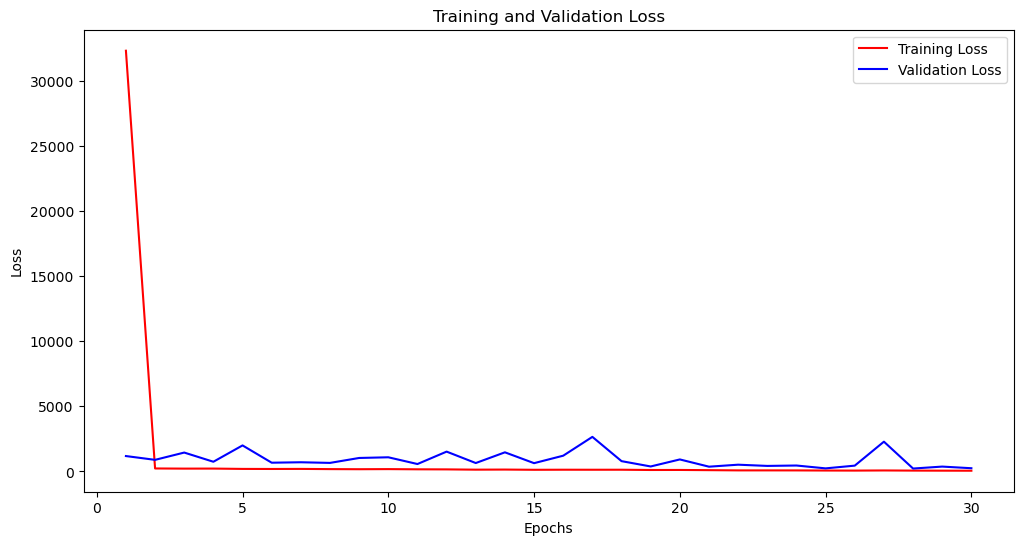

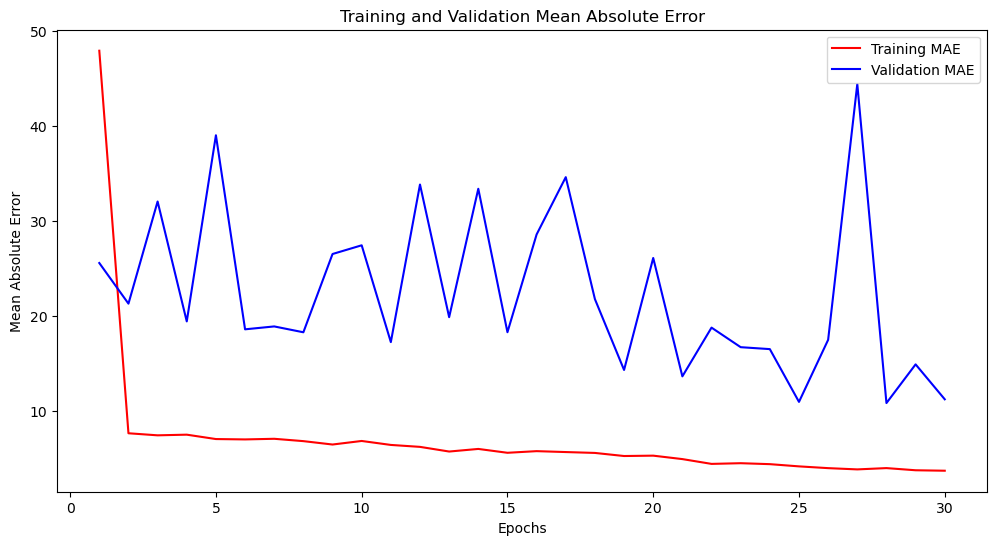

In [24]:
low_params = pd.read_csv('../hyperparameters/Low_best_params.csv').to_dict(orient='records')[0]

# Convert regularizer strings to actual regularizer instances.
low_params['dense_regularizer'] = parse_regularizer(low_params['dense_regularizer'])
low_params['lstm_regularizer'] = parse_regularizer(low_params['lstm_regularizer'])

low_model = CreateModel('Low', date_df_train, X_low_train, y_low_train, WINDOW_SIZE, params=low_params)

 5/32 [===>..........................] - ETA: 0s

2023-04-30 14:08:09.551396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


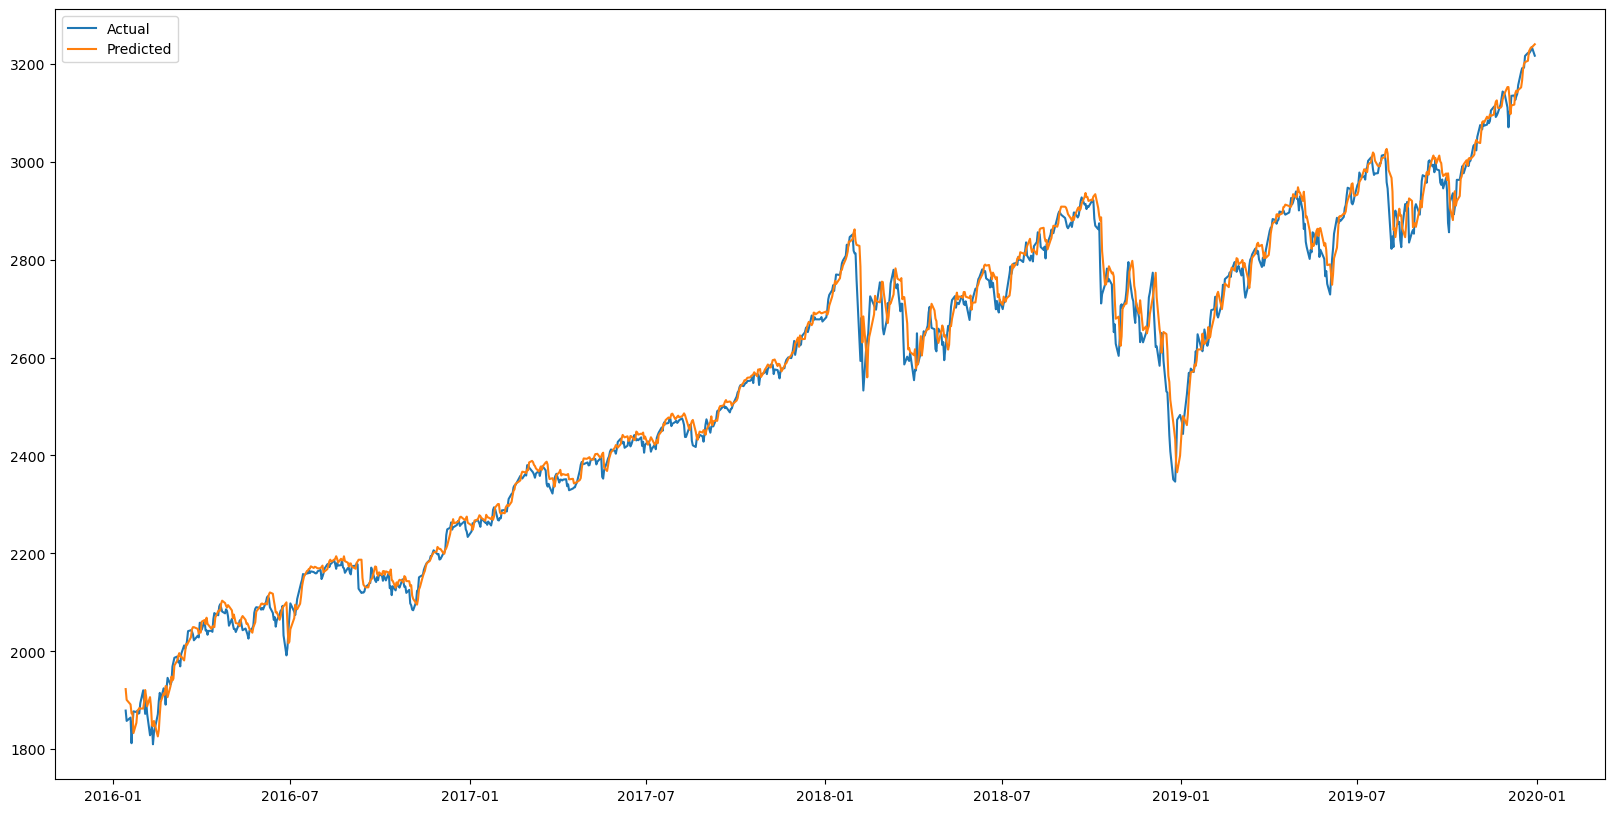

In [25]:
low_predictions = low_model.best_model.predict(X_low_test).flatten()

plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Low'][date_df_all.size-date_df_test.size:], label='Actual')
plt.plot(date_df_test, low_predictions, label='Predicted')
plt.legend()

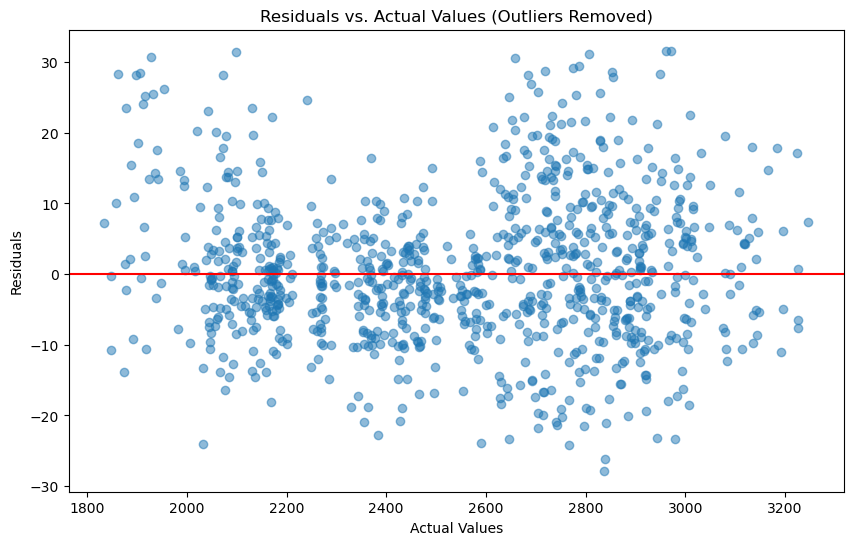

In [26]:
# Plot residuals
residuals = y_open_test - low_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_open_test[np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()

In [40]:
low_model.best_model.save('../models/low_model.h5')

### Volume

Using GPU
Using best hyperparameters from previous run
Epoch 1/30


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_151/2792147926.py:82: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-30 14:08:10.810444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - ETA: 0s - loss: 41739196557164544.0000 - mean_absolute_error: 84063360.0000

2023-04-30 14:09:54.407788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - 111s 78ms/step - loss: 41739196557164544.0000 - mean_absolute_error: 84063360.0000 - val_loss: 3018993397814788096.0000 - val_mean_absolute_error: 1388351104.0000
Epoch 2/30
1410/1410 [==============================] - 119s 84ms/step - loss: 14181250793209856.0000 - mean_absolute_error: 50149624.0000 - val_loss: 864468614789464064.0000 - val_mean_absolute_error: 685363520.0000
Epoch 3/30
1410/1410 [==============================] - 125s 89ms/step - loss: 8502268403908608.0000 - mean_absolute_error: 37646532.0000 - val_loss: 455643528425373696.0000 - val_mean_absolute_error: 450692032.0000
Epoch 4/30
1410/1410 [==============================] - 120s 85ms/step - loss: 6155693694386176.0000 - mean_absolute_error: 31184536.0000 - val_loss: 424536179812073472.0000 - val_mean_absolute_error: 437283168.0000
Epoch 5/30
1410/1410 [==============================] - 115s 82ms/step - loss: 6072544201277440.0000 - mean_absolute_error: 31451496.0000 - val

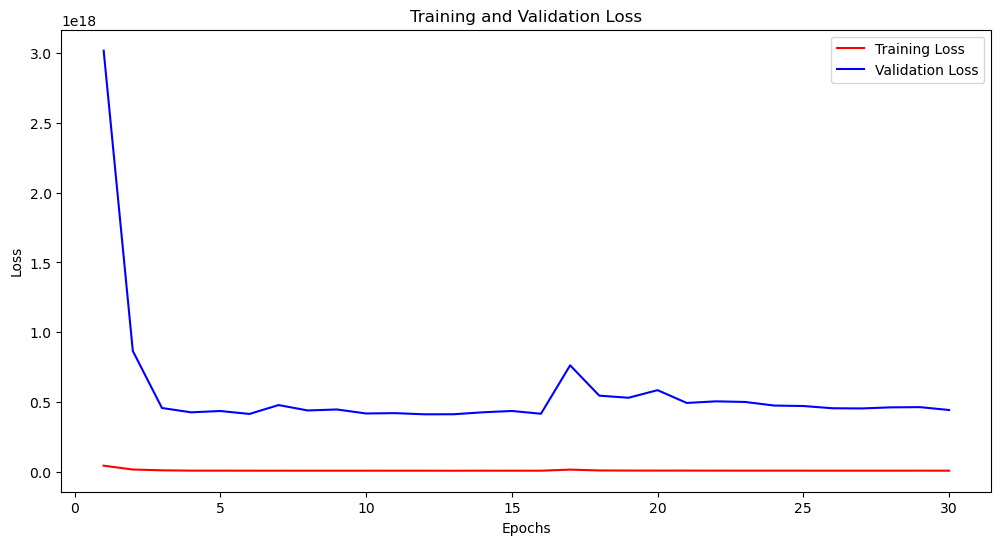

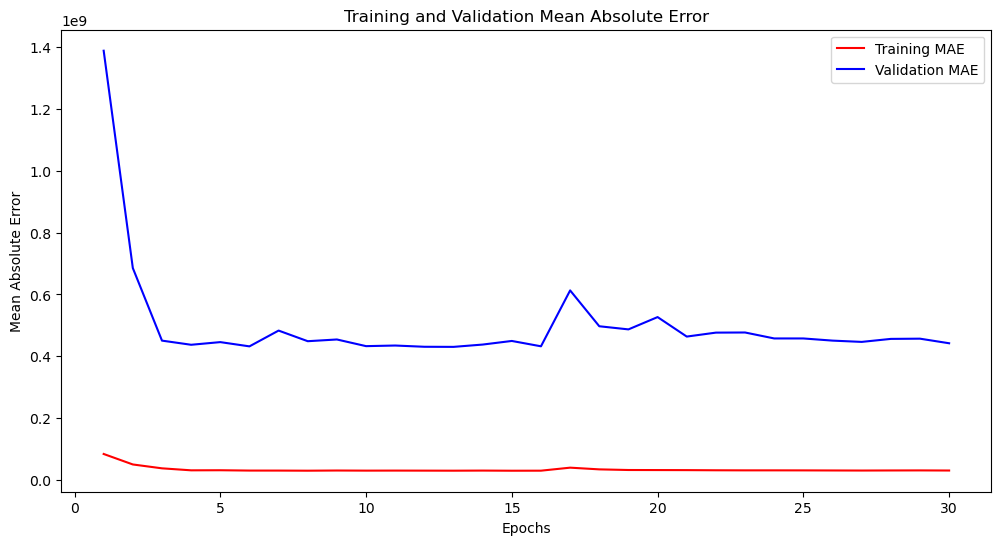

In [28]:
volume_params = pd.read_csv('../hyperparameters/Volume_best_params.csv').to_dict(orient='records')[0]

# Convert regularizer strings to actual regularizer instances.
volume_params['dense_regularizer'] = parse_regularizer(volume_params['dense_regularizer'])
volume_params['lstm_regularizer'] = parse_regularizer(volume_params['lstm_regularizer'])

volume_model = CreateModel('Volume', date_df_train, X_volume_train, y_volume_train, WINDOW_SIZE, params=volume_params)

 5/32 [===>..........................] - ETA: 0s

2023-04-30 15:09:07.846936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


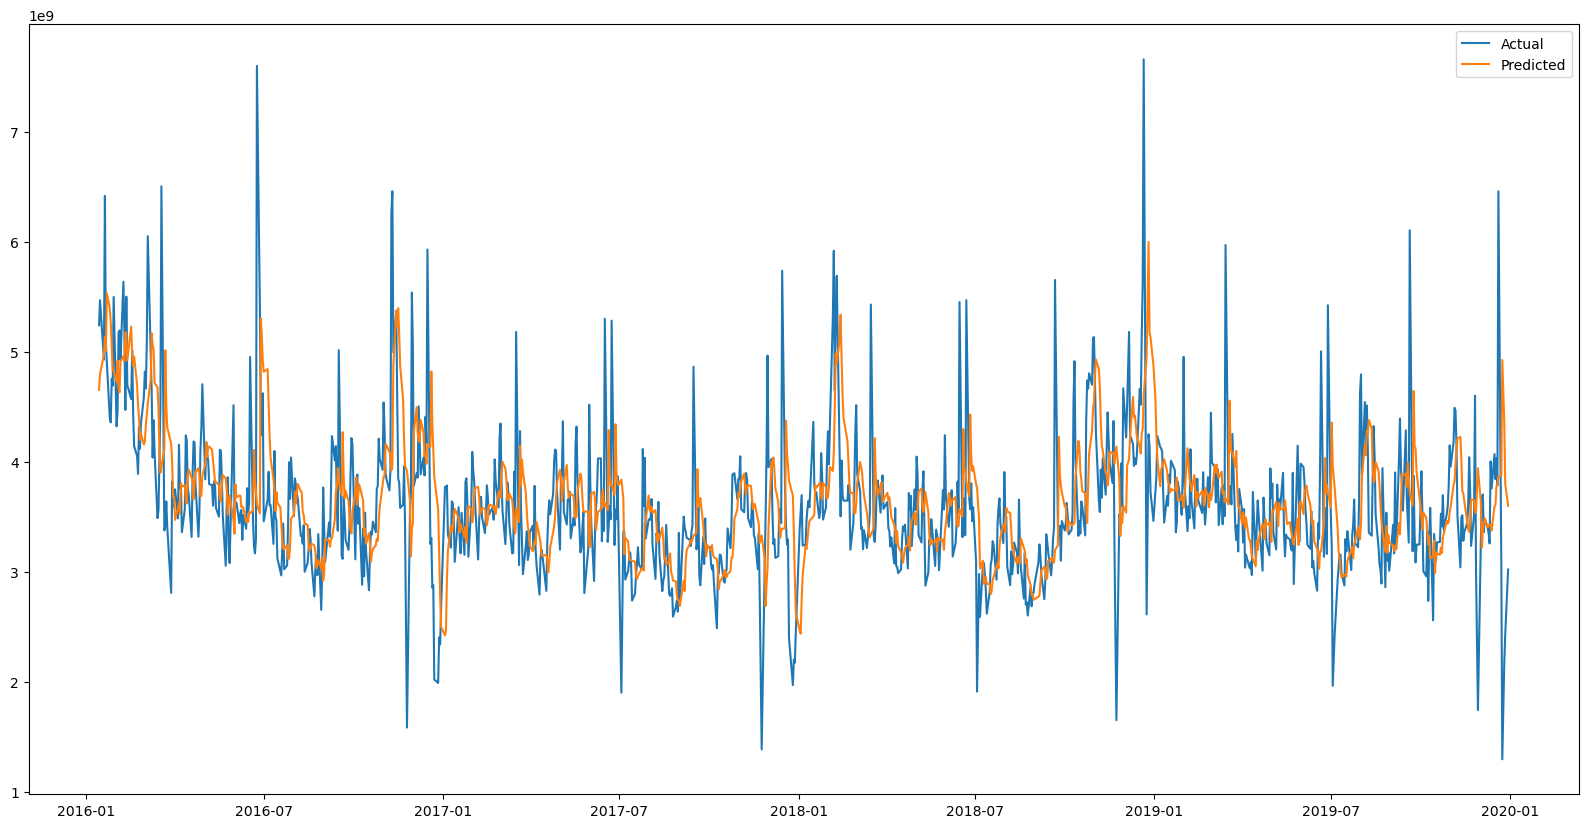

In [29]:
volume_predictions = volume_model.best_model.predict(X_volume_test).flatten()

plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Volume'][date_df_all.size-date_df_test.size:], label='Actual')
plt.plot(date_df_test, volume_predictions, label='Predicted')
plt.legend()

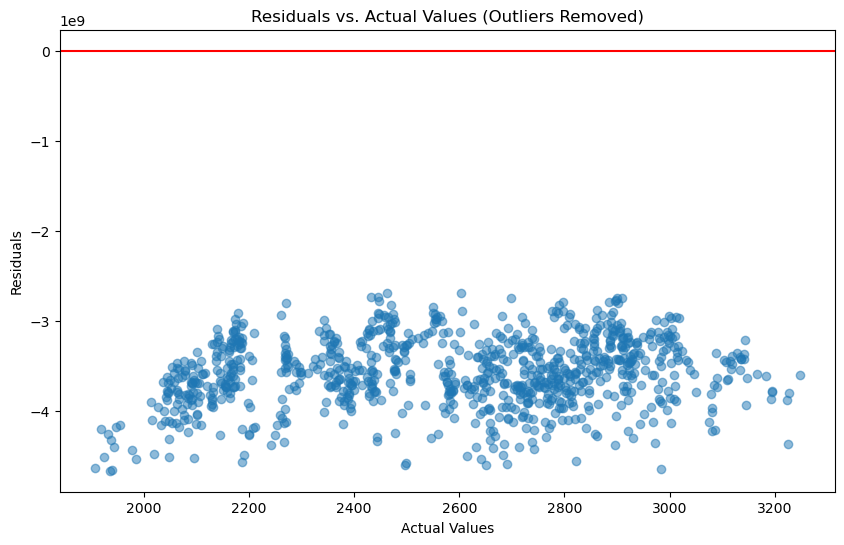

In [30]:
# Plot residuals
residuals = y_open_test - volume_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_open_test[np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()

In [41]:
volume_model.best_model.save('../models/volume_model.h5')

## Restore models
You have to run this even when you're training

In [42]:
open_model = tf.keras.models.load_model('../models/open_model.h5')
high_model = tf.keras.models.load_model('../models/high_model.h5')
low_model = tf.keras.models.load_model('../models/low_model.h5')
volume_model = tf.keras.models.load_model('../models/volume_model.h5')

In [43]:
open_predictions = open_model.predict(X_open_test).flatten()
high_predictions = high_model.predict(X_high_test).flatten()
low_predictions = low_model.predict(X_low_test).flatten()
volume_predictions = volume_model.predict(X_volume_test).flatten()

 1/32 [..............................] - ETA: 6s

2023-04-30 16:20:35.947543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-04-30 16:20:36.759579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-04-30 16:20:37.385012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-04-30 16:20:38.002979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


## Save Predictions to CSV

In [49]:
open_predictions.tofile('../predictions/open_predictions.csv', sep=',')
high_predictions.tofile('../predictions/high_predictions.csv', sep=',')
low_predictions.tofile('../predictions/low_predictions.csv', sep=',')
volume_predictions.tofile('../predictions/volume_predictions.csv', sep=',')

## Plot Restored Model

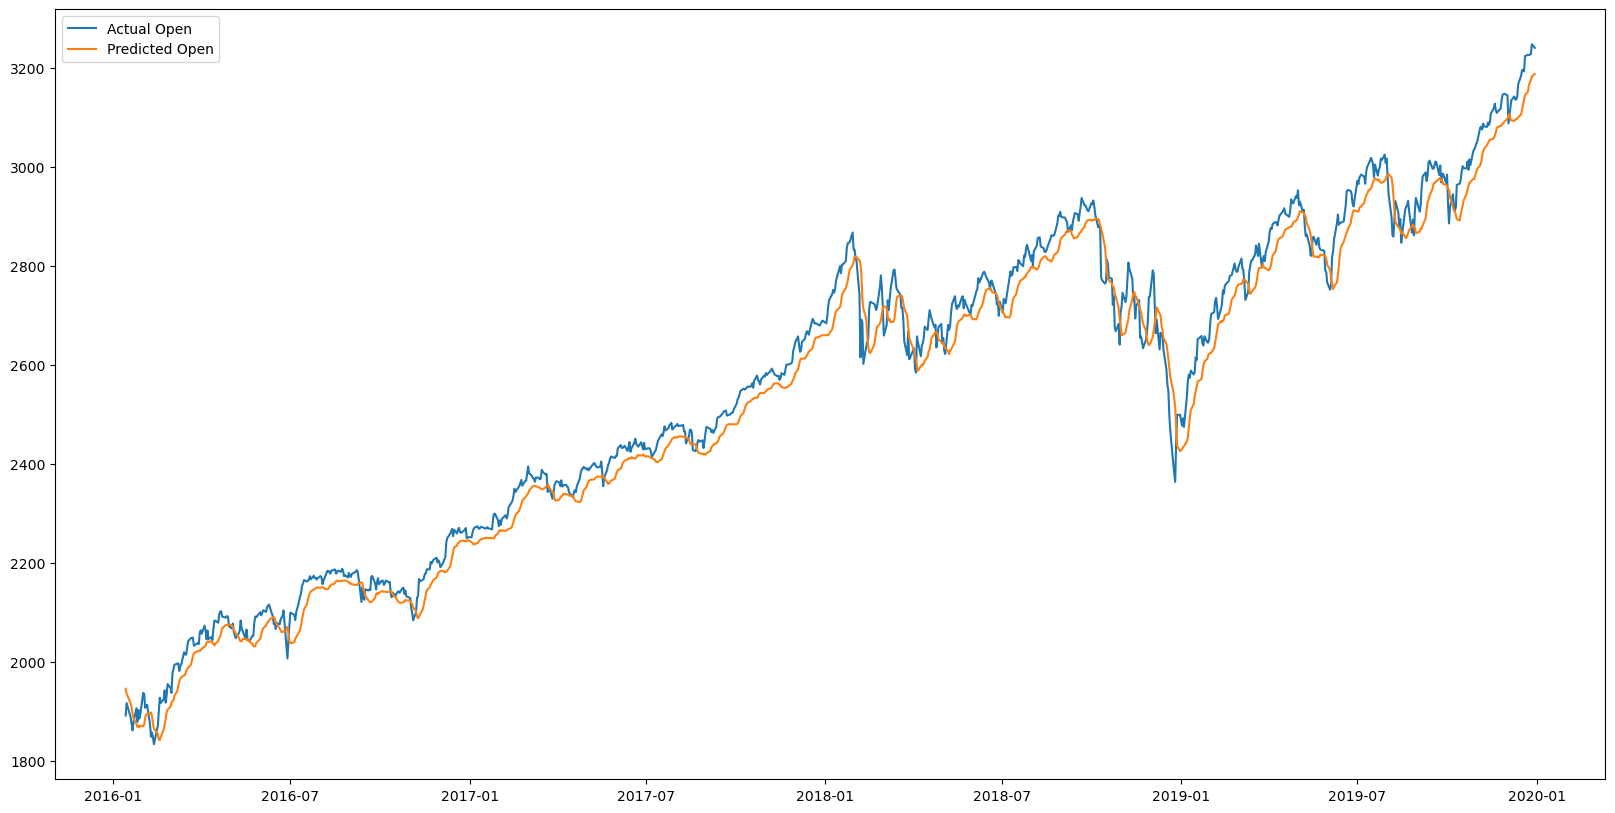

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Open'][date_df_all.size-date_df_test.size:], label='Actual Open')
plt.plot(date_df_test, open_predictions, label='Predicted Open')
plt.legend()

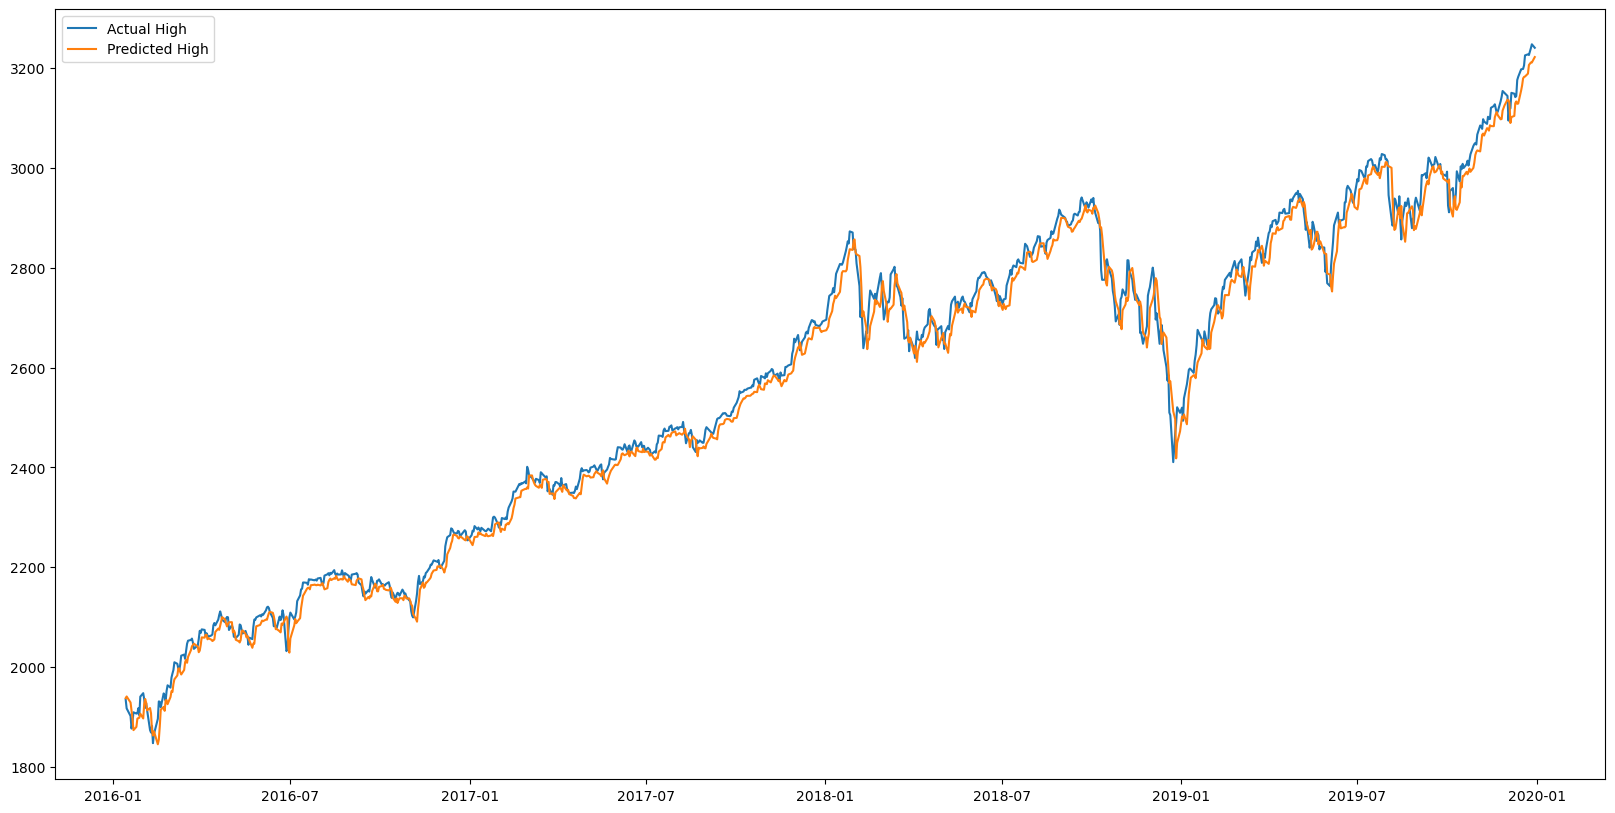

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['High'][date_df_all.size-date_df_test.size:], label='Actual High')
plt.plot(date_df_test, high_predictions, label='Predicted High')
plt.legend()

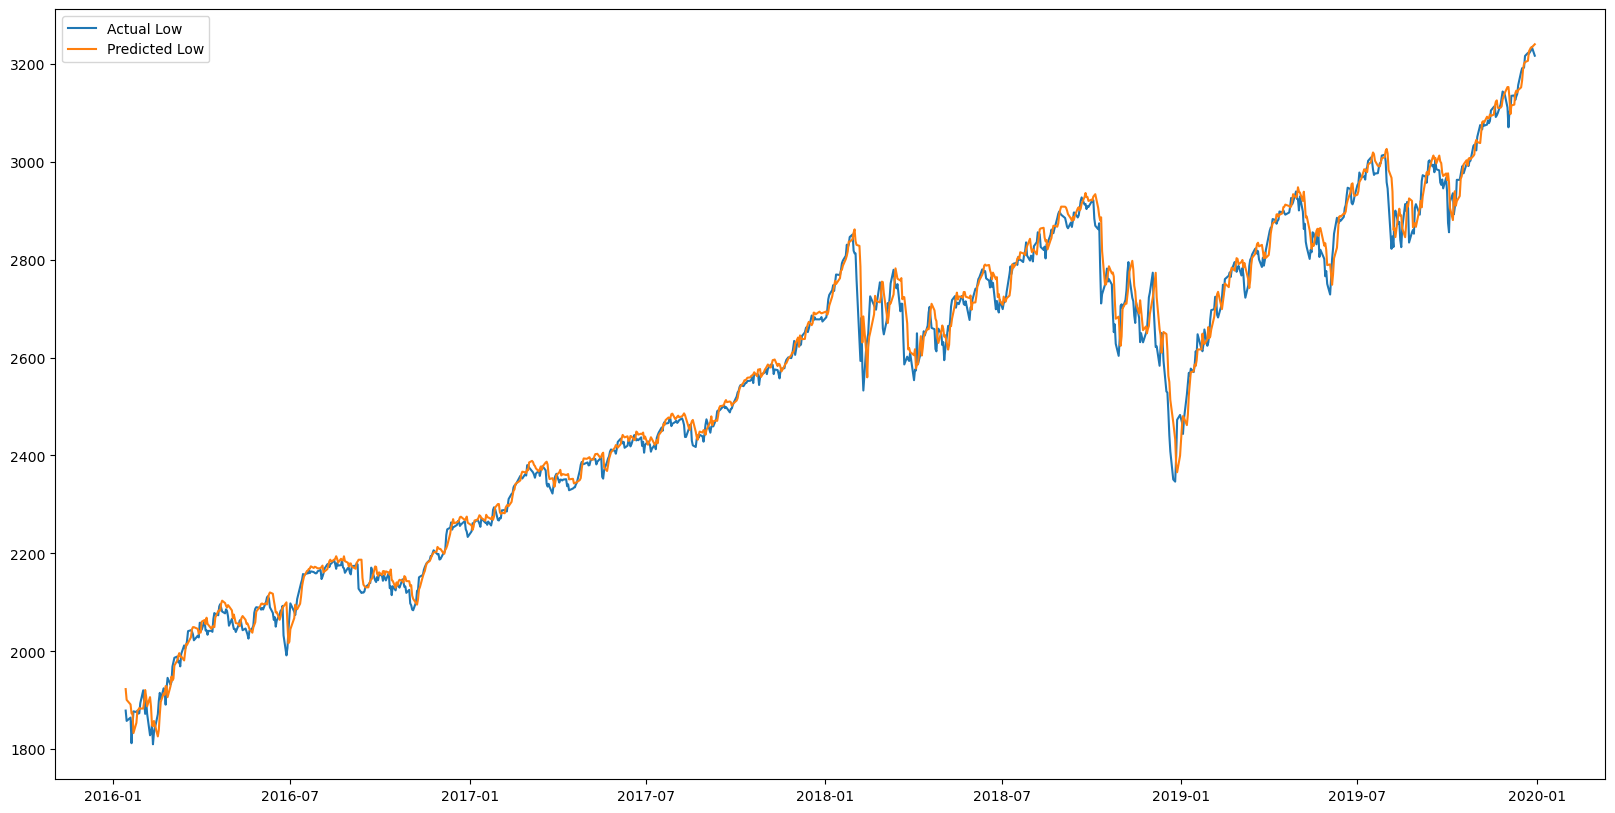

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Low'][date_df_all.size-date_df_test.size:], label='Actual Low')
plt.plot(date_df_test, low_predictions, label='Predicted Low')
plt.legend()

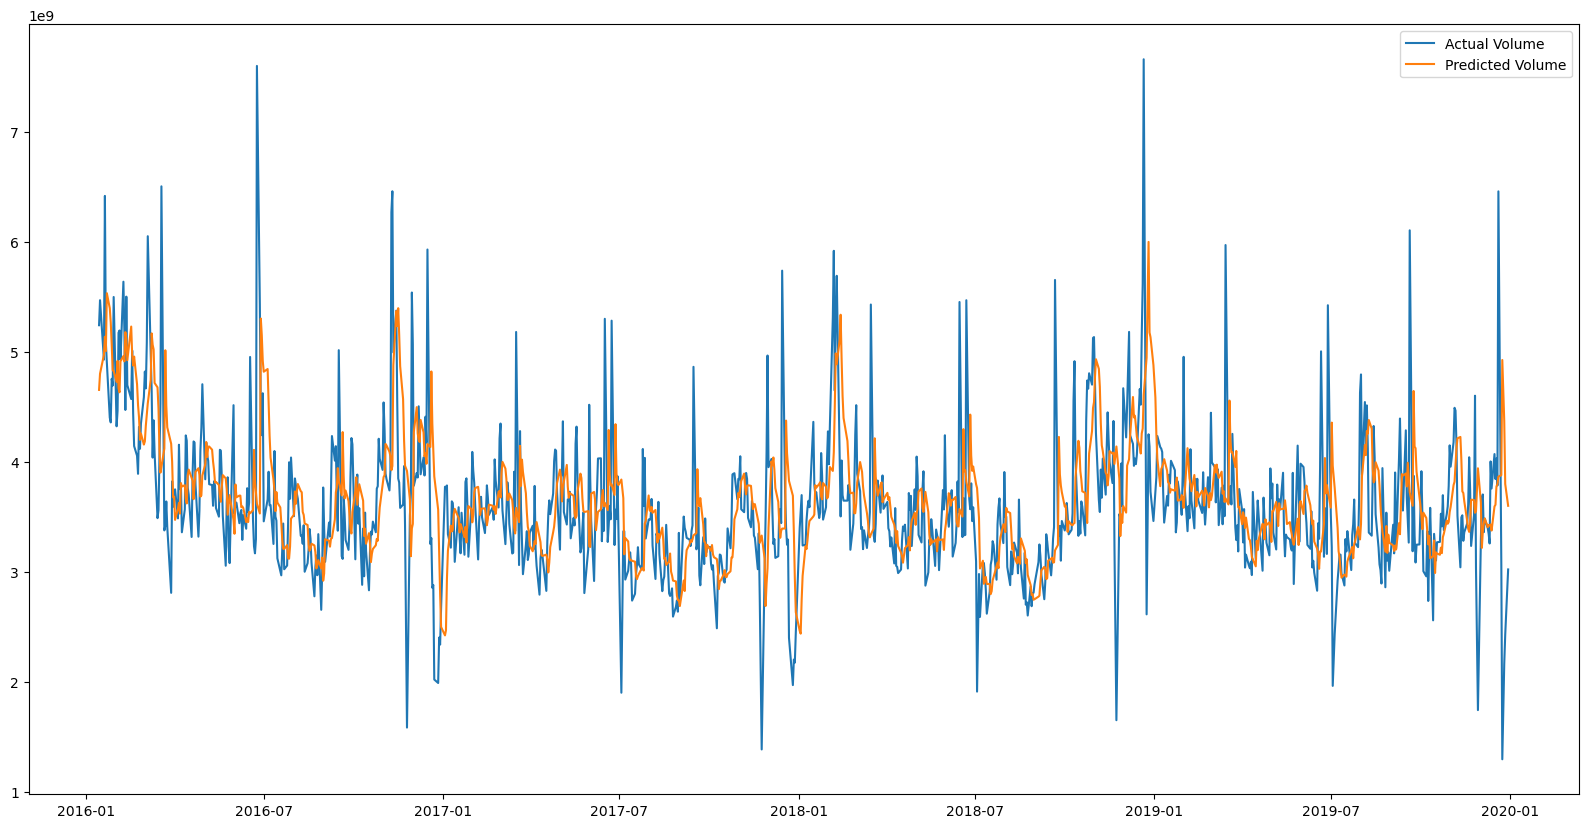

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(date_df_all[date_df_all.size-date_df_test.size:], df['Volume'][date_df_all.size-date_df_test.size:], label='Actual Volume')
plt.plot(date_df_test, volume_predictions, label='Predicted Volume')
plt.legend()